In [1]:
!pip install speechbrain librosa transformers datasets accelerate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.1/864.1 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Basic imports
import os
import math
import json
import logging
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Audio processing
import librosa

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Transformers
from transformers import (
    Wav2Vec2Processor, 
    Wav2Vec2ForSequenceClassification,
    Wav2Vec2Config,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Datasets
from datasets import Dataset as HFDataset

# Configure settings
warnings.filterwarnings('ignore')
torch.manual_seed(42)
np.random.seed(42)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

logger.info(f"PyTorch version: {torch.__version__}")
logger.info(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    logger.info(f"GPU: {torch.cuda.get_device_name(0)}")

2025-07-19 10:52:37.339526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752922357.675846      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752922357.769973      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Initialize W&B (with error handling)
try:
    from kaggle_secrets import UserSecretsClient
    import wandb
    
    user_secrets = UserSecretsClient()
    wandb_key = user_secrets.get_secret("wandb_api_key")
    wandb.login(key=wandb_key)
    WANDB_ENABLED = True
    print("W&B initialized successfully")
except Exception as e:
    print(f"W&B initialization failed: {e}")
    WANDB_ENABLED = False

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nekloyh (nekloyh-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


W&B initialized successfully


In [4]:
# Dataset paths - adjust these based on your Kaggle dataset
CREMAD = "/kaggle/input/cremad/AudioWAV/"
RAVDESS = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
SAVEE = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"
TESS = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/"

# Initialize dataframe
audios = pd.DataFrame(columns=["Dataset", "Path", "Emotion"])

# Check if datasets exist
datasets_found = []
if os.path.exists(CREMAD):
    datasets_found.append("CREMA-D")
    logger.info(f"CREMA-D dataset found: {len(os.listdir(CREMAD))} files")
else:
    logger.warning("CREMA-D dataset not found!")

if os.path.exists(RAVDESS):
    datasets_found.append("RAVDESS")
    logger.info(f"RAVDESS dataset found: {len(os.listdir(RAVDESS))} files")
else:
    logger.warning("RAVDESS dataset not found!")

if os.path.exists(SAVEE):
    datasets_found.append("SAVEE")
    logger.info(f"SAVEE dataset found: {len(os.listdir(SAVEE))} files")
else:
    logger.warning("SAVEE dataset not found!")

if os.path.exists(TESS):
    datasets_found.append("TESS")
    logger.info(f"TESS dataset found: {len(os.listdir(TESS))} files")
else:
    logger.warning("TESS dataset not found!")

logger.info(f"Available datasets: {datasets_found}")

In [5]:
def load_cremad_dataset():
    """Load CREMA-D dataset with proper error handling"""
    emotion_map_cremad = {
        "DIS": "Disgust", 
        "SAD": "Sad", 
        "HAP": "Happy", 
        "NEU": "Neutral", 
        "FEA": "Fearful", 
        "ANG": "Angry"
    }
    
    cremad_data = []
    
    if not os.path.exists(CREMAD):
        logger.warning("CREMA-D dataset not found, skipping...")
        return cremad_data
    
    files = os.listdir(CREMAD)
    logger.info(f"Processing {len(files)} CREMA-D files...")
    
    for file in tqdm(files, desc="Loading CREMA-D"):
        try:
            if file.endswith('.wav'):
                parts = file.split("_")
                if len(parts) >= 3:
                    emotion_code = parts[2]
                    if emotion_code in emotion_map_cremad:
                        emotion = emotion_map_cremad[emotion_code]
                        cremad_data.append({
                            "Dataset": "CREMA-D", 
                            "Path": os.path.join(CREMAD, file), 
                            "Emotion": emotion
                        })
        except Exception as e:
            logger.warning(f"Error processing file {file}: {str(e)}")
    
    logger.info(f"Loaded {len(cremad_data)} CREMA-D samples")
    return cremad_data

# Load CREMA-D data
cremad_data = load_cremad_dataset()
for item in cremad_data:
    audios.loc[len(audios)] = item

Loading CREMA-D:   0%|          | 0/7442 [00:00<?, ?it/s]

In [6]:
def load_ravdess_dataset():
    """Load RAVDESS dataset with proper error handling"""
    emotion_map_ravdess = {
        1: "Neutral", 
        2: "Calm", 
        3: "Happy", 
        4: "Sad", 
        5: "Angry", 
        6: "Fearful", 
        7: "Disgust", 
        8: "Surprised"
    }
    
    ravdess_data = []
    
    if not os.path.exists(RAVDESS):
        logger.warning("RAVDESS dataset not found, skipping...")
        return ravdess_data
    
    folders = os.listdir(RAVDESS)
    logger.info(f"Processing {len(folders)} RAVDESS folders...")
    
    for folder in tqdm(folders, desc="Loading RAVDESS"):
        folder_path = os.path.join(RAVDESS, folder)
        if os.path.isdir(folder_path):
            files = os.listdir(folder_path)
            for file in files:
                try:
                    if file.endswith('.wav'):
                        parts = file.split("-")
                        if len(parts) >= 3:
                            emotion_code = int(parts[2])
                            if emotion_code in emotion_map_ravdess:
                                emotion = emotion_map_ravdess[emotion_code]
                                ravdess_data.append({
                                    "Dataset": "RAVDESS", 
                                    "Path": os.path.join(folder_path, file), 
                                    "Emotion": emotion
                                })
                except Exception as e:
                    logger.warning(f"Error processing file {file}: {str(e)}")
    
    logger.info(f"Loaded {len(ravdess_data)} RAVDESS samples")
    return ravdess_data

# Load RAVDESS data
ravdess_data = load_ravdess_dataset()
for item in ravdess_data:
    audios.loc[len(audios)] = item

Loading RAVDESS:   0%|          | 0/24 [00:00<?, ?it/s]

In [7]:
def load_savee_dataset():
    """Load SAVEE dataset with proper error handling"""
    emotion_map_savee = {
        "a": "Angry",
        "d": "Disgust",
        "f": "Fearful",
        "h": "Happy",
        "n": "Neutral",
        "sa": "Sad",
        "su": "Surprised",
    }

    savee_data = []

    if not os.path.exists(SAVEE):
        logger.warning("SAVEE dataset not found, skipping...")
        return savee_data

    files = os.listdir(SAVEE)
    logger.info(f"Processing {len(files)} SAVEE files...")

    for file in tqdm(files, desc="Loading SAVEE"):
        try:
            if file.endswith(".wav"):
                # SAVEE filename format: [speaker_id][emotion_code][sentence_id].wav
                # Example: DC_a01.wav, DC_d01.wav, etc.
                filename_without_ext = file.replace(".wav", "")
                parts = filename_without_ext.split("_")

                if len(parts) >= 2:
                    emotion_part = parts[1]  # e.g., "a01", "d01", "sa01"

                    # Extract emotion code (handle both single and double character codes)
                    emotion_code = None
                    if emotion_part.startswith("sa"):
                        emotion_code = "sa"
                    elif emotion_part.startswith("su"):
                        emotion_code = "su"
                    elif len(emotion_part) > 0:
                        emotion_code = emotion_part[
                            0
                        ]  # First character for single codes

                    if emotion_code and emotion_code in emotion_map_savee:
                        emotion = emotion_map_savee[emotion_code]
                        savee_data.append(
                            {
                                "Dataset": "SAVEE",
                                "Path": os.path.join(SAVEE, file),
                                "Emotion": emotion,
                            }
                        )
        except Exception as e:
            logger.warning(f"Error processing file {file}: {str(e)}")

    logger.info(f"Loaded {len(savee_data)} SAVEE samples")
    return savee_data


# Load SAVEE data
savee_data = load_savee_dataset()
for item in savee_data:
    audios.loc[len(audios)] = item

Loading SAVEE:   0%|          | 0/480 [00:00<?, ?it/s]

In [8]:
def load_tess_dataset():
    """Load TESS dataset with proper error handling"""
    # TESS has emotions in folder structure and filenames
    emotion_map_tess = {
        "angry": "Angry",
        "disgust": "Disgust",
        "fear": "Fearful",
        "happy": "Happy",
        "neutral": "Neutral",
        "sad": "Sad",
    }

    tess_data = []

    if not os.path.exists(TESS):
        logger.warning("TESS dataset not found, skipping...")
        return tess_data

    # TESS dataset is organized in subdirectories
    total_files = 0
    for root, dirs, files in os.walk(TESS):
        total_files += len([f for f in files if f.endswith(".wav")])

    logger.info(f"Processing {total_files} TESS files...")

    with tqdm(total=total_files, desc="Loading TESS") as pbar:
        for root, dirs, files in os.walk(TESS):
            for file in files:
                try:
                    if file.endswith(".wav"):
                        # TESS filename format: [speaker]_[word]_[emotion].wav
                        # Example: YAF_back_angry.wav, OAF_dog_happy.wav
                        filename_without_ext = file.replace(".wav", "")
                        parts = filename_without_ext.split("_")

                        if len(parts) >= 3:
                            emotion_code = parts[-1].lower()  # Last part is emotion

                            if emotion_code in emotion_map_tess:
                                emotion = emotion_map_tess[emotion_code]
                                tess_data.append(
                                    {
                                        "Dataset": "TESS",
                                        "Path": os.path.join(root, file),
                                        "Emotion": emotion,
                                    }
                                )

                        pbar.update(1)

                except Exception as e:
                    logger.warning(f"Error processing file {file}: {str(e)}")
                    pbar.update(1)

    logger.info(f"Loaded {len(tess_data)} TESS samples")
    return tess_data

# Load TESS data
tess_data = load_tess_dataset()
for item in tess_data:
    audios.loc[len(audios)] = item

Loading TESS:   0%|          | 0/2800 [00:00<?, ?it/s]

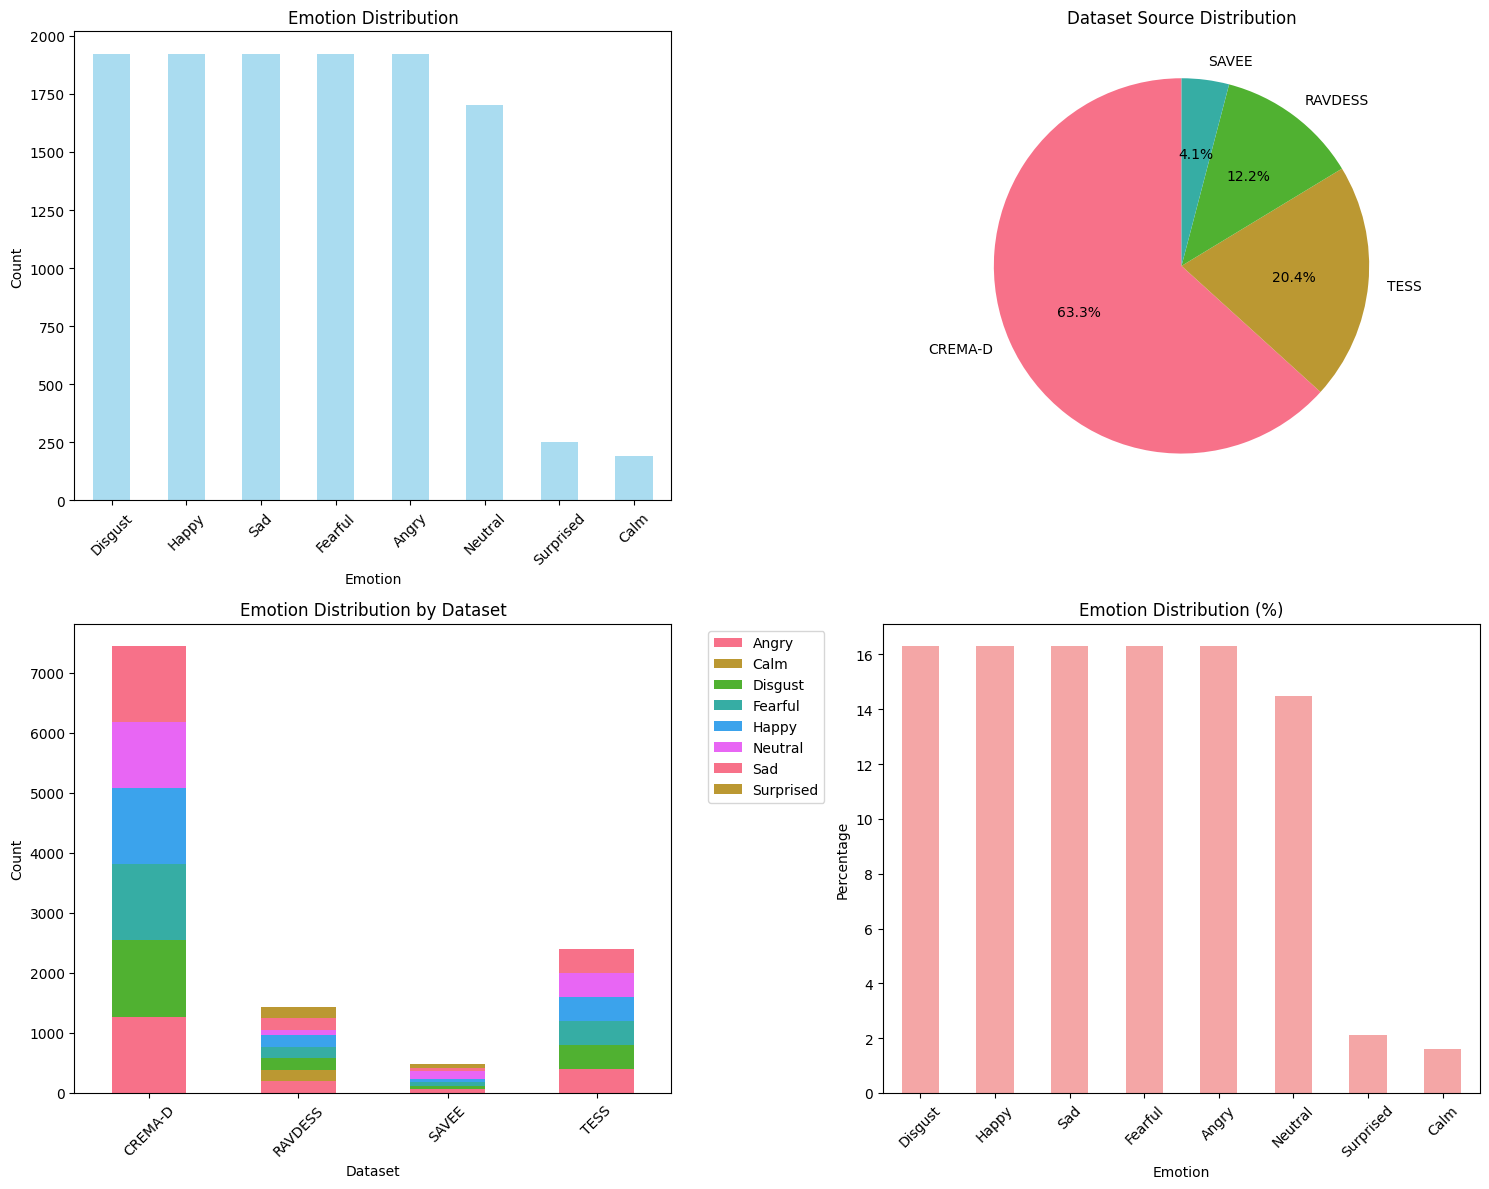

In [9]:
def explore_dataset(df):
    """Comprehensive dataset exploration"""
    logger.info(f"Total dataset size: {len(df)} samples")
    
    # Check for missing values
    missing_data = df.isnull().sum()
    if missing_data.any():
        logger.warning(f"Missing values found:\n{missing_data}")
        df = df.dropna()
        logger.info(f"After removing missing values: {len(df)} samples")
    
    # Unique emotions
    unique_emotions = df['Emotion'].unique()
    logger.info(f"Unique emotions: {list(unique_emotions)}")
    logger.info(f"Number of emotion classes: {len(unique_emotions)}")
    
    # Emotion distribution
    emotion_counts = df['Emotion'].value_counts()
    logger.info(f"Emotion distribution:\n{emotion_counts}")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Emotion distribution bar plot
    emotion_counts.plot(kind='bar', ax=axes[0,0], color='skyblue', alpha=0.7)
    axes[0,0].set_title('Emotion Distribution')
    axes[0,0].set_xlabel('Emotion')
    axes[0,0].set_ylabel('Count')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Dataset source distribution
    if 'Dataset' in df.columns:
        dataset_counts = df['Dataset'].value_counts()
        dataset_counts.plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%', startangle=90)
        axes[0,1].set_title('Dataset Source Distribution')
        axes[0,1].set_ylabel('')
        
        # Emotion distribution by dataset
        pd.crosstab(df['Dataset'], df['Emotion']).plot(kind='bar', ax=axes[1,0], stacked=True)
        axes[1,0].set_title('Emotion Distribution by Dataset')
        axes[1,0].set_xlabel('Dataset')
        axes[1,0].set_ylabel('Count')
        axes[1,0].tick_params(axis='x', rotation=45)
        axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Emotion percentage
    emotion_pct = (emotion_counts / len(df) * 100).round(1)
    emotion_pct.plot(kind='bar', ax=axes[1,1], color='lightcoral', alpha=0.7)
    axes[1,1].set_title('Emotion Distribution (%)')
    axes[1,1].set_xlabel('Emotion')
    axes[1,1].set_ylabel('Percentage')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return df

# Explore the dataset
audios = explore_dataset(audios)

# Save the dataset
audios.to_csv("audio_files.csv", index=False)
logger.info("Dataset saved to audio_files.csv")

In [10]:
class AudioEmotionDataset(Dataset):
    """Custom dataset for audio emotion recognition"""
    
    def __init__(self, dataframe, processor, target_sampling_rate=16000, max_length_seconds=10):
        self.data = dataframe.reset_index(drop=True)
        self.processor = processor
        self.target_sampling_rate = target_sampling_rate
        self.max_length = target_sampling_rate * max_length_seconds
        
        # Encode labels
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(dataframe['Emotion'])
        self.num_labels = len(self.label_encoder.classes_)
        
        logger.info(f"Dataset initialized with {len(self.data)} samples")
        logger.info(f"Labels: {list(self.label_encoder.classes_)}")
        logger.info(f"Number of classes: {self.num_labels}")
        
        # Compute class weights for imbalanced dataset
        self.class_weights = compute_class_weight(
            'balanced', 
            classes=np.unique(self.labels), 
            y=self.labels
        )
        logger.info(f"Class weights: {dict(zip(self.label_encoder.classes_, self.class_weights))}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        audio_path = self.data.iloc[idx]['Path']
        
        try:
            # Load audio file
            audio_array, sample_rate = librosa.load(audio_path, sr=None)
            
            # Resample if necessary
            if sample_rate != self.target_sampling_rate:
                audio_array = librosa.resample(
                    audio_array, 
                    orig_sr=sample_rate, 
                    target_sr=self.target_sampling_rate
                )
            
            # Truncate if too long
            if len(audio_array) > self.max_length:
                audio_array = audio_array[:self.max_length]
            
            # Process audio
            inputs = self.processor(
                audio_array,
                sampling_rate=self.target_sampling_rate,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=self.max_length
            )
            
            return {
                'input_values': inputs.input_values.squeeze(),
                'attention_mask': inputs.attention_mask.squeeze() if 'attention_mask' in inputs else torch.ones(len(audio_array)),
                'labels': torch.tensor(self.labels[idx], dtype=torch.long)
            }
            
        except Exception as e:
            logger.warning(f"Error loading audio file {audio_path}: {str(e)}")
            # Return dummy data for problematic files
            return {
                'input_values': torch.zeros(self.max_length),
                'attention_mask': torch.ones(self.max_length),
                'labels': torch.tensor(0, dtype=torch.long)
            }

def collate_fn(batch):
    """Custom collate function for DataLoader"""
    input_values = []
    attention_masks = []
    labels = []
    
    # Find max length in batch
    max_length = max(item['input_values'].shape[0] for item in batch)
    
    for item in batch:
        input_val = item['input_values']
        
        # Pad to max length
        if input_val.shape[0] < max_length:
            padding = torch.zeros(max_length - input_val.shape[0])
            input_val = torch.cat([input_val, padding])
        
        input_values.append(input_val)
        
        # Create attention mask
        attention_mask = item.get('attention_mask', torch.ones(len(input_val)))
        if attention_mask.shape[0] < max_length:
            mask_padding = torch.zeros(max_length - attention_mask.shape[0])
            attention_mask = torch.cat([attention_mask, mask_padding])
        
        attention_masks.append(attention_mask)
        labels.append(item['labels'])

    return {
        'input_values': torch.stack(input_values),
        'attention_mask': torch.stack(attention_masks),
        'labels': torch.stack(labels)
    }

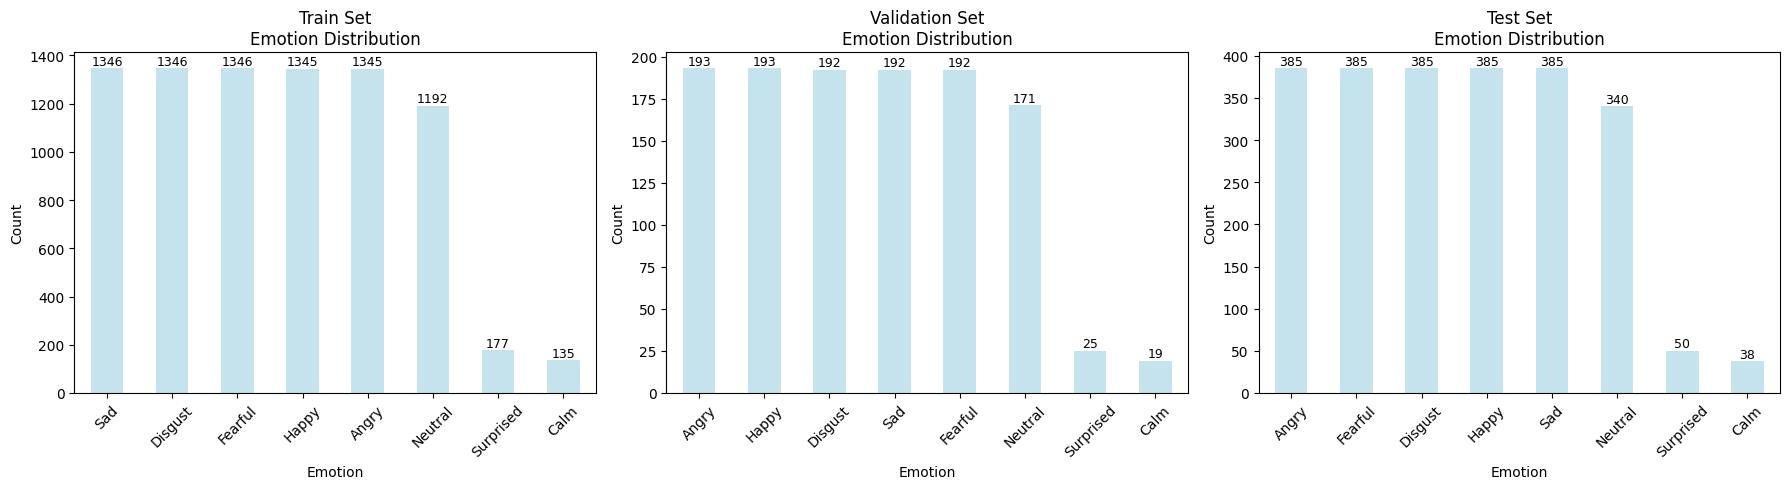

In [11]:
def split_dataset(df, test_size=0.2, val_size=0.1, random_state=42):
    """Split dataset into train/validation/test sets"""
    logger.info("Splitting dataset...")
    
    # First split: separate test set
    train_val_df, test_df = train_test_split(
        df, 
        test_size=test_size, 
        stratify=df['Emotion'], 
        random_state=random_state
    )
    
    # Second split: separate validation from training
    val_size_adjusted = val_size / (1 - test_size)
    train_df, val_df = train_test_split(
        train_val_df, 
        test_size=val_size_adjusted, 
        stratify=train_val_df['Emotion'], 
        random_state=random_state
    )
    
    logger.info(f"Dataset split:")
    logger.info(f"  Training: {len(train_df)} samples ({len(train_df)/len(df)*100:.1f}%)")
    logger.info(f"  Validation: {len(val_df)} samples ({len(val_df)/len(df)*100:.1f}%)")
    logger.info(f"  Test: {len(test_df)} samples ({len(test_df)/len(df)*100:.1f}%)")
    
    # Visualize split distribution
    splits = {'Train': train_df, 'Validation': val_df, 'Test': test_df}
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, (split_name, split_df) in enumerate(splits.items()):
        emotion_counts = split_df['Emotion'].value_counts()
        bars = emotion_counts.plot(kind='bar', ax=axes[idx], color='lightblue', alpha=0.7)
        axes[idx].set_title(f'{split_name} Set\nEmotion Distribution')
        axes[idx].set_xlabel('Emotion')
        axes[idx].set_ylabel('Count')
        axes[idx].tick_params(axis='x', rotation=45)
        
        # Add count labels on bars
        for bar in bars.patches:
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                         f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    return train_df, val_df, test_df

# Split the dataset
train_df, val_df, test_df = split_dataset(audios)

In [12]:
def setup_model_and_processor(model_name="facebook/wav2vec2-base", num_labels=None):
    """Setup Wav2Vec2 model and processor"""
    logger.info(f"Setting up model: {model_name}")
    
    # Load processor
    logger.info("Loading processor...")
    processor = Wav2Vec2Processor.from_pretrained(model_name)
    
    # Configure model
    logger.info("Configuring model...")
    config = Wav2Vec2Config.from_pretrained(model_name)
    
    if num_labels:
        config.num_labels = num_labels
    
    # Add dropout for regularization
    config.classifier_dropout = 0.1
    config.hidden_dropout = 0.1
    config.attention_dropout = 0.1
    
    # Load model
    logger.info("Loading model...")
    model = Wav2Vec2ForSequenceClassification.from_pretrained(
        model_name,
        config=config,
        ignore_mismatched_sizes=True
    )
    
    # Freeze feature extractor to speed up training
    model.freeze_feature_extractor()
    logger.info("Feature extractor frozen")
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    logger.info("Model parameters:")
    logger.info(f"  Total: {total_params:,}")
    logger.info(f"  Trainable: {trainable_params:,}")
    logger.info(f"  Frozen: {total_params - trainable_params:,}")
    
    return model, processor

# Setup model and processor
model, processor = setup_model_and_processor(num_labels=len(audios['Emotion'].unique()))

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def create_datasets(train_df, val_df, test_df, processor):
    """Create dataset objects for training"""
    logger.info("Creating dataset objects...")
    
    datasets = {}
    
    with tqdm(total=3, desc="Creating datasets") as pbar:
        # Training dataset
        pbar.set_description("Creating training dataset")
        datasets['train'] = AudioEmotionDataset(train_df, processor)
        pbar.update(1)
        
        # Validation dataset
        pbar.set_description("Creating validation dataset")  
        datasets['val'] = AudioEmotionDataset(val_df, processor)
        pbar.update(1)
        
        # Test dataset
        pbar.set_description("Creating test dataset")
        datasets['test'] = AudioEmotionDataset(test_df, processor)
        pbar.update(1)
    
    logger.info("All datasets created successfully")
    
    # Verify datasets have same label encoding
    train_labels = set(datasets['train'].label_encoder.classes_)
    val_labels = set(datasets['val'].label_encoder.classes_)
    test_labels = set(datasets['test'].label_encoder.classes_)
    
    if train_labels != val_labels or train_labels != test_labels:
        logger.warning("Label encoders have different classes across datasets!")
    
    return datasets

# Create datasets
datasets = create_datasets(train_df, val_df, test_df, processor)
train_dataset = datasets['train']
val_dataset = datasets['val']
test_dataset = datasets['test']

Creating datasets:   0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
def setup_training_arguments(output_dir="./results"):
    """Setup training arguments"""
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=20,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=20,
        eval_strategy="steps",
        eval_steps=50,
        save_strategy="steps",
        save_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model="eval_accuracy",
        greater_is_better=True,
        save_total_limit=2,
        dataloader_num_workers=2,
        remove_unused_columns=False,
        push_to_hub=False,
        report_to="wandb",  
        seed=42
    )
    
    return training_args

# Setup training arguments
training_args = setup_training_arguments()

In [15]:
def compute_metrics(eval_pred):
    """Compute metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    
    return {
        'accuracy': accuracy,
    }

def evaluate_model(model, test_dataset, processor):
    """Evaluate model on test set"""
    logger.info("Evaluating model on test set...")

    # Create test dataloader
    test_dataloader = DataLoader(
        test_dataset, 
        batch_size=8, 
        shuffle=False, 
        collate_fn=collate_fn
    )
    
    model.eval()
    all_predictions = []
    all_labels = []
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Evaluating"):
            input_values = batch['input_values'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_values=input_values, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    
    logger.info(f"Test Accuracy: {accuracy:.4f}")
    
    # Classification report
    class_names = test_dataset.label_encoder.classes_
    report = classification_report(
        all_labels, 
        all_predictions, 
        target_names=class_names,
        output_dict=True
    )
    
    logger.info("Classification Report:")
    logger.info(classification_report(all_labels, all_predictions, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return accuracy, report, cm

In [16]:
def train_model(model, train_dataset, val_dataset, training_args):
    """Train the model"""
    logger.info("Starting training...")
    wandb.init(project="speech-to-emoji", entity="nekloyh-none")

    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        data_collator=collate_fn,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )
    
    # Train
    trainer.train()
    
    # Save model
    trainer.save_model()
    logger.info("Model saved successfully")

    wandb.finish()
    return trainer

# Train the model
trainer = train_model(model, train_dataset, val_dataset, training_args)

wandb: Tracking run with wandb version 0.20.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250719_105321-y48xjkdu
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run lively-brook-13
wandb: ⭐️ View project at https://wandb.ai/nekloyh-none/speech-to-emoji
wandb: 🚀 View run at https://wandb.ai/nekloyh-none/speech-to-emoji/runs/y48xjkdu
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Accuracy
50,1.955500,1.847080,0.279524
100,1.650200,1.663770,0.343246
150,1.538400,1.582105,0.401869
200,1.382200,1.487559,0.445200
250,1.292100,1.259605,0.576890
300,1.121500,1.177076,0.584537
350,1.003600,0.973338,0.692438
400,0.865200,0.899834,0.713679
450,0.801000,0.822048,0.734919
500,0.734400,0.801322,0.738318


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           eval/accuracy ▁▂▃▃▅▅▆▇▇▇▇▇▇█████▇█████████
wandb:               eval/loss █▇▇▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▂▁▂▁▁
wandb:            eval/runtime ▇▁▆▇▂▂▂▇▇▁▂▃█▂▂▂▇▇▄▁▂▇▇▂▂▃▇▇
wandb: eval/samples_per_second ▂█▃▂▇▇▇▂▂█▇▆▁▇▇▇▂▂▅█▇▂▂▇▇▆▂▂
wandb:   eval/steps_per_second ▂█▃▂▇▇▇▂▂█▇▆▁▇▇▇▂▂▅█▇▂▂▇▇▆▂▂
wandb:             train/epoch ▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇████
wandb:       train/global_step ▁▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█████
wandb:         train/grad_norm ▁▁▁▂▄▃█▃▂▅▆▃▅▄▄▄▄▄▄▅▅▆▆▃▅▆▄▃▆▃▆▂▄▅▆▅▅▃▄▄
wandb:     train/learning_rate ▁▃▅▆██████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄
wandb:              train/loss █▇▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:            eval/accuracy 0.81648
wandb:                eval/loss 0.65222
wandb:             eval/runtime 17.8793
wandb:  eval/samples_per_second 65.83
wandb:    eval/steps_per_second 1.063
w

Evaluating:   0%|          | 0/295 [00:00<?, ?it/s]

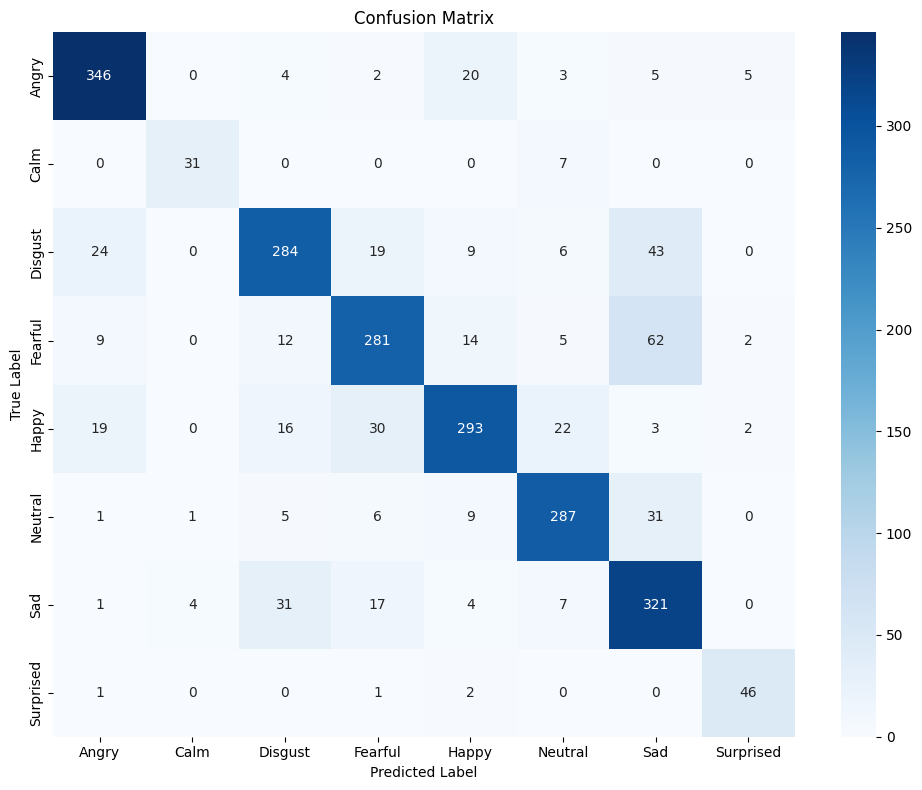

In [17]:
# Evaluate on test set
test_accuracy, test_report, test_cm = evaluate_model(model, test_dataset, processor)

# Print summary
logger.info("="*50)
logger.info("TRAINING SUMMARY")
logger.info("="*50)
logger.info(f"Total samples: {len(audios)}")
logger.info(f"Number of classes: {len(audios['Emotion'].unique())}")
logger.info(f"Test accuracy: {test_accuracy:.4f}")
logger.info("="*50)